In [4]:
import pandas as pd
import numpy as np
import os
from sklearn import preprocessing

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#plt.rc('font', family='Malgun Gothic')

In [6]:
#train과 test데이터 병합

DATA_DIR = 'space_Data'
datalist = []
for filename in os.listdir('space_Data')[::-1]:
    if filename in ['train.csv', 'test.csv']:
        filepath = os.path.join(DATA_DIR, filename)
        df = pd.read_csv(filepath)
        datalist.append(df)
    if filename in ['train.csv']:
        filepath = os.path.join(DATA_DIR, filename)
        train = pd.read_csv(filepath)
    if filename in ['test.csv']:
        filepath = os.path.join(DATA_DIR, filename)
        test = pd.read_csv(filepath)

merge_data = pd.concat(datalist)
merge_data = merge_data.reset_index(drop=True)
y_value = merge_data.pop('Transported').values
y_value = y_value[:8693] #train.shape이 (8693, 14)

#####뜯어보기

In [7]:
#결측치 비율이 60%이상인 컬럼은 중요하지 않을 경우, 삭제하기 위해, 각 컬럼별 결측치 비율 확인
#결측치 비율이 60% 이상인 컬럼이 없으므로 모두 결측치 삽입해서 사용

total_count = merge_data.shape[0]
condition = (merge_data.isna().sum() > 0).values
(merge_data.isna().sum()/total_count)[condition].sort_values(ascending =False)

CryoSleep       0.023901
ShoppingMall    0.023593
Cabin           0.023053
VIP             0.022822
Name            0.022668
FoodCourt       0.022282
HomePlanet      0.022205
Spa             0.021897
Destination     0.021126
Age             0.020817
VRDeck          0.020663
RoomService     0.020278
dtype: float64

In [8]:
#어떤 행성, 목적지가 있는지 자세한 설명이 없어서 각 컬럼별로 어떤 값이 들어있을 수 있는지 확인

set_col = {}
for i in range(len(merge_data.columns)):
    if merge_data.iloc[:,i].dtypes == 'object':
        set_col[merge_data.columns[i]] = set(merge_data.iloc[:, i])

for k,v in set_col.items():
    print(k,v)

PassengerId {'4113_02', '3610_02', '5863_01', '0897_01', '1369_01', '0654_01', '7707_01', '2899_01', '3675_02', '2199_01', '2184_02', '1767_01', '7952_01', '7878_01', '1819_01', '7311_01', '6905_03', '1003_01', '0222_03', '6091_02', '8796_03', '7014_01', '6787_02', '4258_02', '3868_03', '7943_02', '5655_01', '8975_02', '4986_01', '4988_01', '6428_02', '2215_04', '3169_01', '3314_01', '3527_01', '7156_03', '1910_01', '0358_01', '1186_05', '4646_01', '6433_02', '3687_01', '7555_01', '7392_01', '5628_01', '0764_01', '6283_01', '8260_03', '8847_01', '5428_01', '8793_02', '6876_02', '7765_01', '8663_02', '9220_03', '5414_05', '9072_02', '3227_01', '2954_01', '3100_01', '6055_02', '5219_01', '2540_01', '4653_01', '0648_02', '0163_02', '5197_01', '2214_01', '2758_01', '0133_01', '1841_01', '6334_03', '4871_01', '7500_01', '6373_01', '7882_01', '4326_01', '2036_01', '0036_01', '7507_01', '1882_02', '7085_02', '0992_05', '5180_01', '3422_01', '6030_07', '6132_01', '5222_01', '4769_01', '0578_02

In [9]:
#승객 나이 최솟값 0, 최댓값 79
merge_data['Age'].apply(['min','max'])

min     0.0
max    79.0
Name: Age, dtype: float64

#####전처리

In [10]:
#결측값 처리
#문자형은 최빈값, / 실수, 정수형은 평균값 삽입

for i in range(len(merge_data.columns)):
    if merge_data.iloc[:, i].dtypes == 'object':
        merge_data.iloc[:, i].fillna(merge_data.iloc[:, i].mode()[0], inplace=True)
    elif merge_data.iloc[:, i].dtypes != 'object':
        merge_data.iloc[:, i].fillna(merge_data.iloc[:, i].mean(), inplace=True)

In [11]:
#PassengerId : gggg_pp 함께 여행하는 그룹_그룹 내에서의 번호, 그룹에 있는 사람들은 대부분 가족이므로 gggg를 'group'새로운 컬럼으로 생성
#Cabin열은 갑판/num/side(P좌측, S우측)으로 구성되어 deck, num, side로 새로운 컬럼 생성

merge_data['group'] = merge_data['PassengerId'].apply(lambda x: x.split('_')[0])  #어떤 그룹에 속하는지
merge_data['deck'] = merge_data['Cabin'].apply(lambda x: x.split('/')[0])
merge_data['num'] = merge_data['Cabin'].apply(lambda x: x.split('/')[1])
merge_data['side'] = merge_data['Cabin'].apply(lambda x: x.split('/')[2]) #객실이 좌측인지 우측인지

#나이는 연령대로 바꿈 
#나이는 0세부터 79세였으므로 0대~70대로 구성됨
merge_data['Age'] = merge_data['Age']//10*10

In [12]:
#동일한 그룹이면 대부분 가족이라고 했기 때문에
#group열을 가족끼리 왔는지, 가족끼리 오지 않았는지 나타내는 True, False로 바꾸기

family_list = merge_data[merge_data.groupby('group')['group'].transform('size') >= 2].index
merge_data['group'] = merge_data.index.isin(family_list).astype(str)

merge_data데이터 전처리 후, 다시 train, test로 분할

In [13]:
train = merge_data[:8693]
train['Transported'] = y_value
test = merge_data[8693:]

C:\Users\samsung\AppData\Local\Temp\ipykernel_28640\4212210441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Transported'] = y_value


######가설

1. 첫번째 목적지에서 내리려던 승객의 이탈율이 크다.

첫번째 목적지는 55 Cancri e였다.
55 Cancri e에 내리려던 승객은 다른 목적지의 승객들보다 이탈이 잘 되었다.

2. 10세 미만의 어린아이일수록 이탈이 잘 된다.

어린아이는 몸이 작아서 이탈이 잘 되었을 수도..? 

3.  VIP 서비스 비용을 지불한 승객의 이탈이 적다.

4. 객실 방향(좌측, 우측)은 이탈에 영향이 있다.

5. 가족끼리 온 승객이 혼자 온 승객보다 이탈이 크다.

가설 1. 첫번째 목적지에서 내리려던 승객의 이탈율이 크다.

In [14]:
#목적지별 비이탈/이탈 비율
train.groupby('Destination')['Transported'].value_counts(normalize=True).unstack(fill_value=0)

Transported,False,True
Destination,,
55 Cancri e,0.390000,0.610000
PSO J318.5-22,0.496231,0.503769
TRAPPIST-1e,0.527801,0.472199


목적지별 비이탈/이탈 비율은
55 Cancri e는 3:6
PSO J318.5-22	5:5
TRAPPIST-1e	5:5

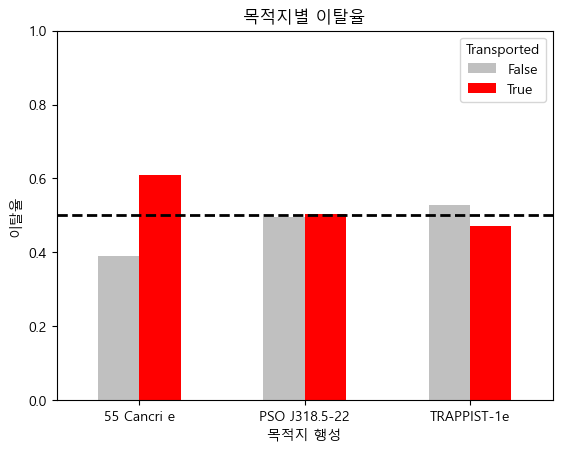

In [27]:
train.groupby('Destination')['Transported'].value_counts(normalize=True).unstack(fill_value=0).plot(kind='bar', stacked=False, color = ['silver','red'])

plt.rc('font', family='Malgun Gothic')
plt.rc('font', family='Malgun Gothic')
plt.title('목적지별 이탈율')
plt.xlabel('목적지 행성')
plt.ylabel('이탈율')
plt.ylim(0,1.0)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=2)
plt.xticks(rotation = 0);

가설2. 10세 미만의 어린아이일수록 이탈이 잘 된다.

연령대가 이탈에 영향이 주었다.
어린아이는 몸이 작아서 이탈이 잘 되었을 수도..?
어린아이는 10세 미만으로 정의함

In [16]:
#연령대별 이탈, 비이탈 비중
train.groupby('Age')['Transported'].value_counts(normalize=True).sort_values(ascending=False).unstack()

Transported,False,True
Age,,
0.0,0.288660,0.711340
10.0,0.467208,0.532792
20.0,0.528732,0.471268
30.0,0.541210,0.458790
40.0,0.493321,0.506679
50.0,0.506284,0.493716
60.0,0.524038,0.475962
70.0,0.565217,0.434783


다른 연령대는 5:5로 이탈, 비이탈 비중이 비등한데 10세 미만 승객수 70%가 이탈함
따라서, 10세 미만의 어린아이일수록 이탈이 잘 된 것으로 보임

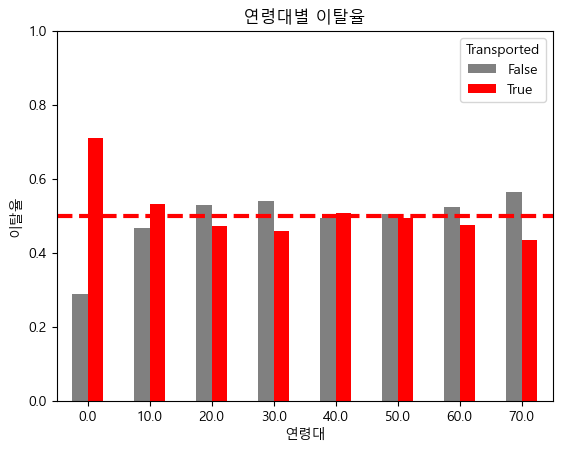

In [17]:
train.groupby('Age')['Transported'].value_counts(normalize=True).sort_values(ascending=False).unstack().plot(kind='bar', stacked=False, color = ['grey','red'])

plt.rc('font', family='Malgun Gothic')
plt.title('연령대별 이탈율')
plt.xlabel('연령대')
plt.ylabel('이탈율')
plt.ylim(0,1.0)
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=3)
plt.xticks(rotation = 0);

3. VIP 서비스 비용을 지불한 승객의 이탈이 적다.

In [18]:
#VIP서비스 비용을 지불한 고객, 지불하지 않은 고객의 수 자체부터 차이가 나서 빈도수 자체로는 비교가 어려움
pd.crosstab(index=train['VIP']
            ,columns = train['Transported']
            #,normalize=True
            ,margins= True
            ,margins_name= '합계')

Transported,False,True,합계
VIP,,,
False,4192,4302,8494
True,123,76,199
합계,4315,4378,8693


In [19]:
#VIP서비스 비용을 지불한 고객, 지불하지 않은 고객별 이탈, 비이탈을 상대도수로 따졌을 때, 
pd.crosstab(index=train['VIP']
            ,columns = train['Transported']
            ,normalize='index'
            )

Transported,False,True
VIP,,
False,0.493525,0.506475
True,0.618090,0.381910


지불여부별 Trans T/F는
VIP서비스 비용을 지불한 고객은  6:4
VIP서비스 비용을 지불하지 않은 고객은  5:5로

VIP서비스 비용을 지불한 고객은 이탈 비중이 적었다고 볼 수 있다.

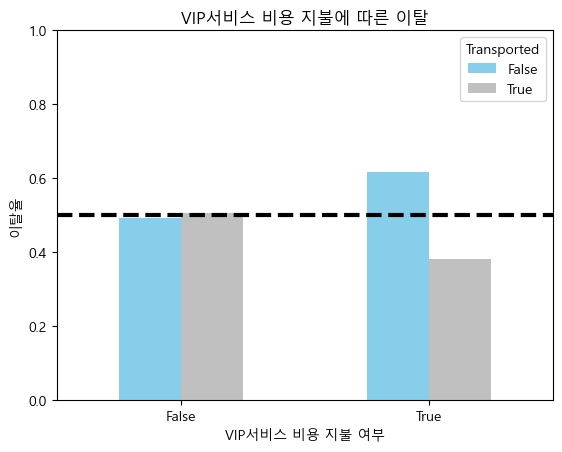

In [20]:
pd.crosstab(index=train['VIP'], columns=train['Transported'], normalize='index').plot(kind='bar', stacked=False, color = ['skyblue','silver'])

plt.rc('font', family='Malgun Gothic')
plt.title('VIP서비스 비용 지불에 따른 이탈')
plt.xlabel('VIP서비스 비용 지불 여부')
plt.ylabel('이탈율')
plt.ylim(0,1.0)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=3)
plt.xticks(rotation = 0);

4. 객실 방향(좌측, 우측)은 이탈에 영향이 있다.

In [21]:
#train.groupby('side')['Transported'].value_counts().unstack(fill_value=0)
pd.crosstab(index=train['side']
            ,columns = train['Transported']
            ,margins= True
            ,margins_name= '합계'
            )

#좌측의 객실을 이용한 승객수, 우측 객실을 이용한 승객수가 균등해보임

Transported,False,True,합계
side,,,
P,2407,1998,4405
S,1908,2380,4288
합계,4315,4378,8693


In [22]:
pd.crosstab(index=train['side']
            ,columns = train['Transported']
            ,normalize='index'
            )

Transported,False,True
side,,
P,0.546425,0.453575
S,0.444963,0.555037


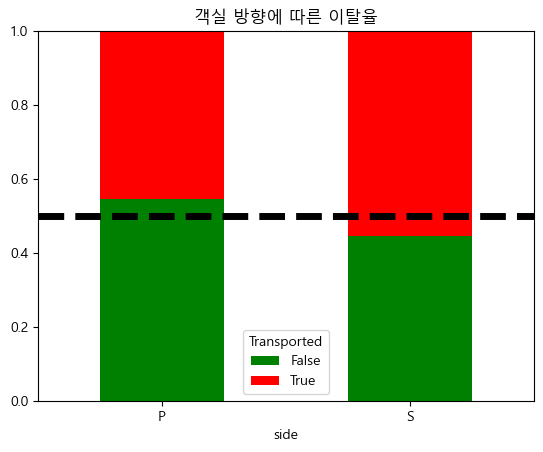

In [32]:
train.groupby('side')['Transported'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, color=['green', 'red'])

plt.rc('font', family='Malgun Gothic')
plt.title('객실 방향에 따른 이탈율')
plt.ylim(0,1.0)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=5)
plt.xticks(rotation = 0);

가설 5. 가족끼리 온 승객이 혼자 온 승객보다 이탈율이 크다.

In [25]:
train.groupby('group')['Transported'].value_counts(normalize=True).unstack()

#가족이 아닌 사람은 45%이탈, 가족인 사람은 57%이탈하였으므로 가설 채택

Transported,False,True
group,,
False,0.547555,0.452445
True,0.433128,0.566872


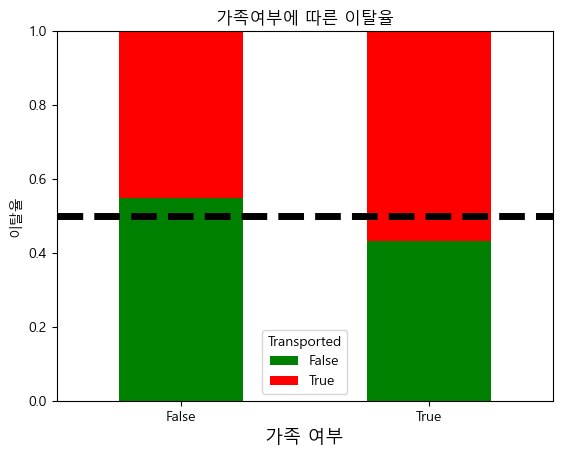

In [26]:
train.groupby('group')['Transported'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True,color=['green', 'red'])

plt.rc('font', family='Malgun Gothic')
plt.title('가족여부에 따른 이탈율')
plt.xlabel('가족 여부', fontsize = 13)
plt.ylabel('이탈율')
plt.ylim(0,1.0)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=5)
plt.xticks(rotation = 0);